BYM and BYM-TDA 

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

from scipy import sparse
from scipy.linalg import solve
from scipy.sparse.linalg import spsolve

import geopandas as gpd

# these libraries are not dependencies of pymc

import networkx as nx
import nutpie
import libpysal as ps

In [2]:
RANDOM_SEED = 8926
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Load the data

In [3]:
# SVI
svi_tda_data = pd.read_csv("/Users/h6x/CODE/Archive/git/spatial-risk-tda/data/processed_data/tda_summaries_2018_WV_down.csv",dtype={'STCNTY':str})

# SMR
smr_data = pd.read_csv("/Users/h6x/CODE/Archive/git/spatial-risk-tda/data/processed_data/smr_data_2018_WV.csv",dtype={'FIPS':str})


# GEO: get geometry data
geo_data = gpd.read_file("/Users/h6x/CODE/Archive/git/spatial-risk-tda/data/raw_data/SVI2018_US_county.gdb", dtype={"FIPS": str})

geo_data = geo_data[['FIPS', 'geometry','ST_ABBR']]

/Users/h6x/anaconda3/envs/pymc_env2/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver OpenFileGDB does not support open option DTYPE
  return ogr_read(


In [4]:
# combine smr on FIPS and svi data on STCNTY - left
combined_data = pd.merge(smr_data, svi_tda_data, left_on="FIPS", right_on="STCNTY", how="left")

# merge combined data with geo data
combined_data = pd.merge(combined_data, geo_data, on="FIPS", how="left")

In [5]:
# print the shape
print(f"Shape of the combined data: {combined_data.shape}")

Shape of the combined data: (55, 89)


In [6]:
# get the 'wv' data

combined_data = combined_data[combined_data['ST_ABBR'] == 'WV']

In [7]:
combined_data.shape

(55, 89)

Cleaning the data: Removing the rows with missing observed deaths, islands, few states

In [8]:
# filter by column to have columns start with EP_ or SMR and geometry and FIPS and observed_death and expected_death
combined_data = combined_data.filter(regex='EP_|SMR|geometry|FIPS|observed_death|expected_death')

# drop the rows with observed_death = 0
combined_data = combined_data[combined_data['observed_deaths'] > 0]

# make it a geodataframe
gdf = gpd.GeoDataFrame(combined_data, geometry='geometry')

# Compute Queen adjacency
w = ps.weights.Queen.from_dataframe(combined_data, ids=combined_data["FIPS"])

# if we keep the islands it will cause error in the adjacency computation(empty adjacencies)
# Get the islands fips to a list
islands = w.islands

# drop the islands
combined_data = combined_data[~combined_data["FIPS"].isin(islands)]

# drop rows with FIPS starts with 72, 78, 02, 15, 60
combined_data = combined_data[~combined_data['FIPS'].str.startswith(('72', '78', '02', '15', '60'))]

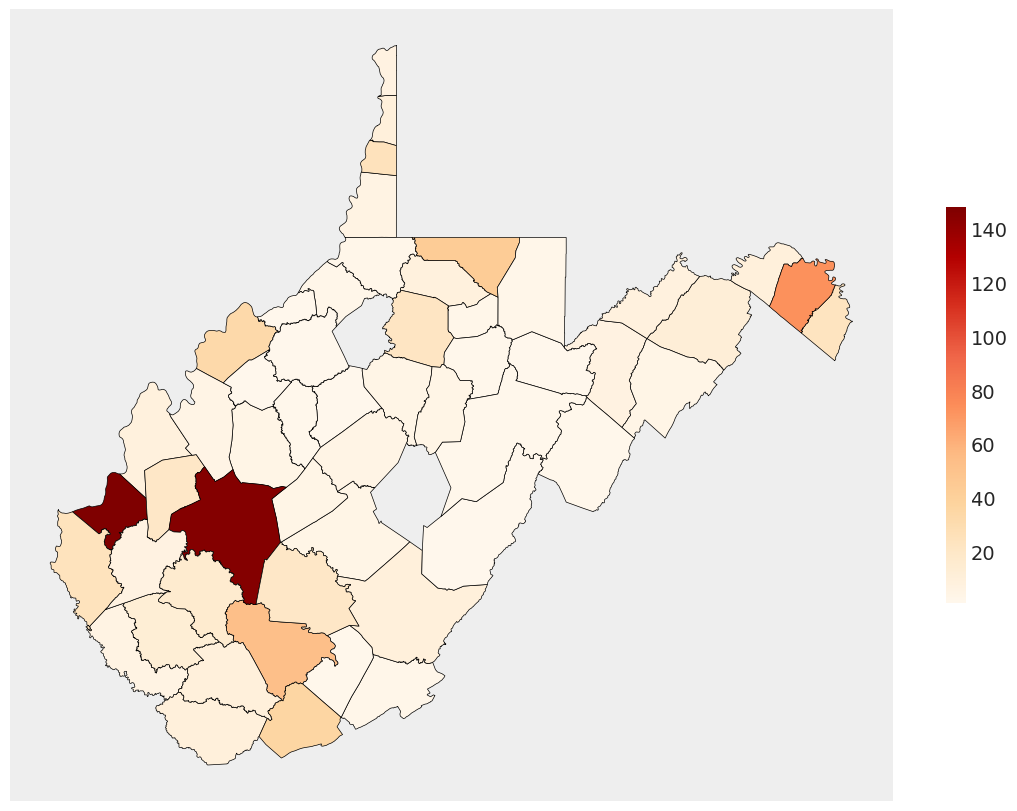

In [9]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot the map with improved aesthetics
gdf.plot(
    column="observed_deaths", 
    ax=ax, 
    legend=True, 
    cmap="OrRd", 
    edgecolor="black", 
    linewidth=0.5,
    legend_kwds={"shrink": 0.5}  # Makes the legend smaller
)

# Add title and labels
# ax.set_title("Observed Deaths by County", fontsize=14, fontweight="bold")
# ax.set_xlabel("Longitude", fontsize=12)
# ax.set_ylabel("Latitude", fontsize=12)

# Remove axis ticks for a cleaner map visualization
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.show()

Combine TDA summaries for each state(all variables)

In [10]:
# get the column names with _AL
al_cols = combined_data.filter(regex='_AL').columns

print(f"Columns with _AL: {al_cols}")

# sum the columns with _AL
combined_data['AL'] = combined_data[al_cols].sum(axis=1)

# drop the columns with _AL
# combined_data.drop(columns=al_cols, inplace=True)

# get the column names with _TL

tl_cols = combined_data.filter(regex='_TL').columns

print(f"Columns with _TL: {tl_cols}")

# sum the columns with _TL
combined_data['TL'] = combined_data[tl_cols].sum(axis=1)

# drop the columns with _TL
# combined_data.drop(columns=tl_cols, inplace=True)

# get the column names with _AML
aml_cols = combined_data.filter(regex='_AML').columns

print(f"Columns with _AML: {aml_cols}")

# sum the columns with _AML
combined_data['AML'] = combined_data[aml_cols].sum(axis=1)

# drop the columns with _AML
# combined_data.drop(columns=aml_cols, inplace=True)

# get the column names with _TML
tml_cols = combined_data.filter(regex='_TML').columns

print(f"Columns with _TML: {tml_cols}")

# sum the columns with _TML
combined_data['TML'] = combined_data[tml_cols].sum(axis=1)

# drop the columns with _TML
# combined_data.drop(columns=tml_cols, inplace=True)

Columns with _AL: Index(['EP_POV_AL', 'EP_UNEMP_AL', 'EP_PCI_AL', 'EP_NOHSDP_AL',
       'EP_UNINSUR_AL', 'EP_AGE65_AL', 'EP_AGE17_AL', 'EP_DISABL_AL',
       'EP_SNGPNT_AL', 'EP_LIMENG_AL', 'EP_MINRTY_AL', 'EP_MUNIT_AL',
       'EP_MOBILE_AL', 'EP_CROWD_AL', 'EP_NOVEH_AL', 'EP_GROUPQ_AL'],
      dtype='object')
Columns with _TL: Index(['EP_POV_TL', 'EP_UNEMP_TL', 'EP_PCI_TL', 'EP_NOHSDP_TL',
       'EP_UNINSUR_TL', 'EP_AGE65_TL', 'EP_AGE17_TL', 'EP_DISABL_TL',
       'EP_SNGPNT_TL', 'EP_LIMENG_TL', 'EP_MINRTY_TL', 'EP_MUNIT_TL',
       'EP_MOBILE_TL', 'EP_CROWD_TL', 'EP_NOVEH_TL', 'EP_GROUPQ_TL'],
      dtype='object')
Columns with _AML: Index(['EP_POV_AML', 'EP_UNEMP_AML', 'EP_PCI_AML', 'EP_NOHSDP_AML',
       'EP_UNINSUR_AML', 'EP_AGE65_AML', 'EP_AGE17_AML', 'EP_DISABL_AML',
       'EP_SNGPNT_AML', 'EP_LIMENG_AML', 'EP_MINRTY_AML', 'EP_MUNIT_AML',
       'EP_MOBILE_AML', 'EP_CROWD_AML', 'EP_NOVEH_AML', 'EP_GROUPQ_AML'],
      dtype='object')
Columns with _TML: Index(['EP_POV_TML', '

Get the adjacency matrix

In [11]:
# create the queen adjacency matrix
w = ps.weights.Queen.from_dataframe(combined_data, ids=combined_data["FIPS"])

# Spatial adjacency matrix (N x N) with binary entries for neighbor relationships.
# make it into a matrix
W = w.full()[0]

Prepare data and adjacency structures: BYM and BYM-TDA

In [12]:
y = combined_data["observed_deaths"].values
E = combined_data["expected_deaths"].values

EP_POV_AV_ORI = combined_data["EP_POV_AV_ORI"].values
EP_UNEMP_AV_ORI = combined_data["EP_UNEMP_AV_ORI"].values
EP_PCI_AV_ORI = combined_data["EP_PCI_AV_ORI"].values
EP_NOHSDP_AV_ORI = combined_data["EP_NOHSDP_AV_ORI"].values
EP_AGE65_AV_ORI = combined_data["EP_AGE65_AV_ORI"].values
EP_AGE17_AV_ORI = combined_data["EP_AGE17_AV_ORI"].values
EP_DISABL_AV_ORI = combined_data["EP_DISABL_AV_ORI"].values
EP_SNGPNT_AV_ORI = combined_data["EP_SNGPNT_AV_ORI"].values
EP_MINRTY_AV_ORI = combined_data["EP_MINRTY_AV_ORI"].values
EP_LIMENG_AV_ORI = combined_data["EP_LIMENG_AV_ORI"].values
EP_MUNIT_AV_ORI = combined_data["EP_MUNIT_AV_ORI"].values
EP_MOBILE_AV_ORI = combined_data["EP_MOBILE_AV_ORI"].values
EP_CROWD_AV_ORI = combined_data["EP_CROWD_AV_ORI"].values
EP_NOVEH_AV_ORI = combined_data["EP_NOVEH_AV_ORI"].values
EP_GROUPQ_AV_ORI = combined_data["EP_GROUPQ_AV_ORI"].values

EP_POV_AL = combined_data["EP_POV_AL"].values
EP_UNEMP_AL = combined_data["EP_UNEMP_AL"].values
EP_PCI_AL = combined_data["EP_PCI_AL"].values
EP_NOHSDP_AL = combined_data["EP_NOHSDP_AL"].values
EP_AGE65_AL = combined_data["EP_AGE65_AL"].values
EP_AGE17_AL = combined_data["EP_AGE17_AL"].values
EP_DISABL_AL = combined_data["EP_DISABL_AL"].values
EP_SNGPNT_AL = combined_data["EP_SNGPNT_AL"].values 
EP_MINRTY_AL = combined_data["EP_MINRTY_AL"].values
EP_LIMENG_AL = combined_data["EP_LIMENG_AL"].values
EP_MUNIT_AL = combined_data["EP_MUNIT_AL"].values
EP_MOBILE_AL = combined_data["EP_MOBILE_AL"].values
EP_CROWD_AL = combined_data["EP_CROWD_AL"].values
EP_NOVEH_AL = combined_data["EP_NOVEH_AL"].values
EP_GROUPQ_AL = combined_data["EP_GROUPQ_AL"].values

AL = combined_data["AL"].values
TL = combined_data["TL"].values
AML = combined_data["AML"].values
TML = combined_data["TML"].values

E[E < 10] = 10
log_E = np.log(E)

area_idx = combined_data["FIPS"].values
coords = {"area_idx": area_idx}

N = len(y)

# # THETA = df_clean["AL"].values
# theta_values = combined_data.set_index("FIPS")["AL"].to_dict()
# theta = np.array([theta_values[fips] for fips in area_idx])

Scaling Factors

In [13]:
def scaling_factor_sp(A):
    """Compute the scaling factor from an adjacency matrix.
    This function uses sparse matrix computations and is most
    efficient on sparse adjacency matrices. Used in the BYM2 model.
    The scaling factor is a measure of the variance in the number of
    edges across nodes in a connected graph.
    Only works for fully connected graphs. The argument for scaling
    factors is developed by Andrea Riebler, Sigrunn H. Sørbye,
    Daniel Simpson, Havard Rue in "An intuitive Bayesian spatial
    model for disease mapping that accounts for scaling"
    https://arxiv.org/abs/1601.01180"""

    # Computes the precision matrix in sparse format
    # from an adjacency matrix.

    num_neighbors = A.sum(axis=1)
    A = sparse.csc_matrix(A)
    D = sparse.diags(num_neighbors, format="csc")
    Q = D - A

    # add a small jitter along the diagonal

    Q_perturbed = Q + sparse.diags(np.ones(Q.shape[0])) * max(Q.diagonal()) * np.sqrt(
        np.finfo(np.float64).eps
    )

    # Compute a version of the pseudo-inverse

    n = Q_perturbed.shape[0]
    b = sparse.identity(n, format="csc")
    Sigma = spsolve(Q_perturbed, b)
    A = np.ones(n)
    W = Sigma @ A.T
    Q_inv = Sigma - np.outer(W * solve(A @ W, np.ones(1)), W.T)

    # Compute the geometric mean of the diagonal on a
    # precision matrix.

    return np.exp(np.sum(np.log(np.diag(Q_inv))) / n)


scaling_factor = scaling_factor_sp(W)
scaling_factor

0.5991931651817699

In [14]:
import pymc as pm
import arviz as az

####  I. PyMC model for the baseline BYM2 (with generic covariates) 

In [15]:
# PyMC model for BYM
with pm.Model(coords=coords) as bym_model:
    
   # Priors for intercept
   intercept = pm.Normal("intercept", mu=0, sigma=1)

   # Priors regression coefficients
   beta_pov = pm.Normal("beta_pov", mu=0, sigma=1)
   beta_unemp = pm.Normal("beta_unemp", mu=0, sigma=1)
   beta_pci = pm.Normal("beta_pci", mu=0, sigma=1)
   beta_nohsdp = pm.Normal("beta_nohsdp", mu=0, sigma=1)
   beta_age65 = pm.Normal("beta_age65", mu=0, sigma=1)
   beta_age17 = pm.Normal("beta_age17", mu=0, sigma=1)
   beta_disabl = pm.Normal("beta_disabl", mu=0, sigma=1)
   beta_sngpnt = pm.Normal("beta_sngpnt", mu=0, sigma=1)
   beta_minrty = pm.Normal("beta_minrty", mu=0, sigma=1)
   beta_limeng = pm.Normal("beta_limeng", mu=0, sigma=1)
   beta_munit = pm.Normal("beta_munit", mu=0, sigma=1)
   beta_mobile = pm.Normal("beta_mobile", mu=0, sigma=1)
   beta_crowd = pm.Normal("beta_crowd", mu=0, sigma=1)
   beta_noveh = pm.Normal("beta_noveh", mu=0, sigma=1)
   beta_groupq = pm.Normal("beta_groupq", mu=0, sigma=1)

   # Spatial structured effect (CAR)
   phi = pm.ICAR("phi", W=W, dims="area_idx")

   # Unstructured random effect (iid)/independent random effect
   theta = pm.Normal("theta", 0, 1, dims="area_idx")

   # the mixing rate is rho
   rho = pm.Beta("rho", 0.5, 0.5)

   # joint variance of random effects(b) - Overall variability parameter (sigma acts as 1/sqrt(tau))
   sigma = pm.HalfNormal("sigma", 1)

   # the bym component - it mixes a spatial and a random effect
   mixture = pm.Deterministic(
   "mixture", pt.sqrt(1 - rho) * theta + pt.sqrt(rho / scaling_factor) * phi, dims="area_idx"
   )

   # exponential link function to ensure
   # predictions are positive

   mu = pm.Deterministic(
      "mu", pt.exp(log_E + 
                  intercept +
                  beta_pov * EP_POV_AV_ORI + 
                  beta_unemp * EP_UNEMP_AV_ORI +
                  beta_pci * EP_PCI_AV_ORI +
                  beta_nohsdp * EP_NOHSDP_AV_ORI +
                  beta_age65 * EP_AGE65_AV_ORI +
                  beta_age17 * EP_AGE17_AV_ORI +
                  beta_disabl * EP_DISABL_AV_ORI +
                  beta_sngpnt * EP_SNGPNT_AV_ORI +
                  beta_minrty * EP_MINRTY_AV_ORI +
                  beta_limeng * EP_LIMENG_AV_ORI +
                  beta_munit * EP_MUNIT_AV_ORI +
                  beta_mobile * EP_MOBILE_AV_ORI +
                  beta_crowd * EP_CROWD_AV_ORI +
                  beta_noveh * EP_NOVEH_AV_ORI +
                  beta_groupq * EP_GROUPQ_AV_ORI +
                  sigma*mixture), dims="area_idx"
   )

   y_i = pm.Poisson("y_i", mu=mu, observed=y, dims="area_idx") # area_idx needed?
   # rr = pm.Deterministic("rr", mu / pt.exp(log_E), dims="area_idx")


Sampling the data

In [ ]:
with bym_model:

    # # Sample from the model:
    trace_bym = pm.sample(draws=4000, tune=1500, chains=4, cores=4, target_accept=0.90, idata_kwargs ={"log_likelihood": True}, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_pov, beta_unemp, beta_pci, beta_nohsdp, beta_age65, beta_age17, beta_disabl, beta_sngpnt, beta_minrty, beta_limeng, beta_munit, beta_mobile, beta_crowd, beta_noveh, beta_groupq, phi, theta, rho, sigma]


/Users/h6x/anaconda3/envs/pymc_env2/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Checking Autocorrlation

In [ ]:
az.plot_autocorr(trace_bym, var_names=["rho", "theta","sigma"], max_lag=100) 
plt.show()

Monte Carlo Error

In [ ]:
summary = az.summary(trace_bym, var_names=["rho", "theta"])
print(summary[["mean", "sd", "ess_bulk", "mcse_mean"]])

# save summary to csv
result_dir = "/Users/h6x/CODE/Archive/git/spatial-risk-tda/results/wv"
summary.to_csv(os.path.join(result_dir, "bym_summary.csv"))

In [ ]:
az.plot_trace(trace_bym)

In [ ]:
az.plot_trace(trace_bym, combined=True)

In [ ]:
az.summary(trace_bym, var_names=["rho"])

Model comparison metrics

In [ ]:
loo_result_base = az.loo(trace_bym)
print(loo_result_base)

In [ ]:
waic_result_base = az.waic(trace_bym)
print(waic_result_base)

####  II. PyMC model for the BYM2 with TDA Features as covariates

In [ ]:
# PyMC model for BYM
with pm.Model(coords=coords) as bym_model_tda_as_features:
    
   # Priors for intercept
   intercept = pm.Normal("intercept", mu=0, sigma=1)

   # Priors regression coefficients
   beta_pov = pm.Normal("beta_pov", mu=0, sigma=1)
   beta_unemp = pm.Normal("beta_unemp", mu=0, sigma=1)
   beta_pci = pm.Normal("beta_pci", mu=0, sigma=1)
   beta_nohsdp = pm.Normal("beta_nohsdp", mu=0, sigma=1)
   beta_age65 = pm.Normal("beta_age65", mu=0, sigma=1)
   beta_age17 = pm.Normal("beta_age17", mu=0, sigma=1)
   beta_disabl = pm.Normal("beta_disabl", mu=0, sigma=1)
   beta_sngpnt = pm.Normal("beta_sngpnt", mu=0, sigma=1)
   beta_minrty = pm.Normal("beta_minrty", mu=0, sigma=1)
   beta_limeng = pm.Normal("beta_limeng", mu=0, sigma=1)
   beta_munit = pm.Normal("beta_munit", mu=0, sigma=1)
   beta_mobile = pm.Normal("beta_mobile", mu=0, sigma=1)
   beta_crowd = pm.Normal("beta_crowd", mu=0, sigma=1)
   beta_noveh = pm.Normal("beta_noveh", mu=0, sigma=1)
   beta_groupq = pm.Normal("beta_groupq", mu=0, sigma=1)

   # Priors for AL features
   beta_pov_al = pm.Normal("beta_pov_al", mu=0, sigma=1)
   beta_unemp_al = pm.Normal("beta_unemp_al", mu=0, sigma=1)
   beta_pci_al = pm.Normal("beta_pci_al", mu=0, sigma=1)
   beta_nohsdp_al = pm.Normal("beta_nohsdp_al", mu=0, sigma=1)
   beta_age65_al = pm.Normal("beta_age65_al", mu=0, sigma=1)
   beta_age17_al = pm.Normal("beta_age17_al", mu=0, sigma=1)
   beta_disabl_al = pm.Normal("beta_disabl_al", mu=0, sigma=1)
   beta_sngpnt_al = pm.Normal("beta_sngpnt_al", mu=0, sigma=1)
   beta_minrty_al = pm.Normal("beta_minrty_al", mu=0, sigma=1)
   beta_limeng_al = pm.Normal("beta_limeng_al", mu=0, sigma=1)
   beta_munit_al = pm.Normal("beta_munit_al", mu=0, sigma=1)
   beta_mobile_al = pm.Normal("beta_mobile_al", mu=0, sigma=1)
   beta_crowd_al = pm.Normal("beta_crowd_al", mu=0, sigma=1)
   beta_noveh_al = pm.Normal("beta_noveh_al", mu=0, sigma=1)
   beta_groupq_al = pm.Normal("beta_groupq_al", mu=0, sigma=1)

   # Spatial structured effect (CAR)
   phi = pm.ICAR("phi", W=W, dims="area_idx")

   # Unstructured random effect (iid)/independent random effect
   theta = pm.Normal("theta", 0, 1, dims="area_idx")

   # the mixing rate is rho
   rho = pm.Beta("rho", 0.5, 0.5)

   # joint variance of random effects(b) - Overall variability parameter (sigma acts as 1/sqrt(tau))
   sigma = pm.HalfNormal("sigma", 1)

   # the bym component - it mixes a spatial and a random effect
   mixture = pm.Deterministic(
   "mixture", pt.sqrt(1 - rho) * theta + pt.sqrt(rho / scaling_factor) * phi, dims="area_idx"
   )

   # exponential link function to ensure
   # predictions are positive

   mu = pm.Deterministic(
      "mu", pt.exp(log_E + 
                  intercept +
                  beta_pov * EP_POV_AV_ORI + 
                  beta_unemp * EP_UNEMP_AV_ORI +
                  beta_pci * EP_PCI_AV_ORI +
                  beta_nohsdp * EP_NOHSDP_AV_ORI +
                  beta_age65 * EP_AGE65_AV_ORI +
                  beta_age17 * EP_AGE17_AV_ORI +
                  beta_disabl * EP_DISABL_AV_ORI +
                  beta_sngpnt * EP_SNGPNT_AV_ORI +
                  beta_minrty * EP_MINRTY_AV_ORI +
                  beta_limeng * EP_LIMENG_AV_ORI +
                  beta_munit * EP_MUNIT_AV_ORI +
                  beta_mobile * EP_MOBILE_AV_ORI +
                  beta_crowd * EP_CROWD_AV_ORI +
                  beta_noveh * EP_NOVEH_AV_ORI +
                  beta_groupq * EP_GROUPQ_AV_ORI +

                  beta_pov_al * EP_POV_AL +
                  beta_unemp_al * EP_UNEMP_AL +
                  beta_pci_al * EP_PCI_AL +
                  beta_nohsdp_al * EP_NOHSDP_AL +
                  beta_age65_al * EP_AGE65_AL +
                  beta_age17_al * EP_AGE17_AL +
                  beta_disabl_al * EP_DISABL_AL +
                  beta_sngpnt_al * EP_SNGPNT_AL +
                  beta_minrty_al * EP_MINRTY_AL +
                  beta_limeng_al * EP_LIMENG_AL +
                  beta_munit_al * EP_MUNIT_AL +
                  beta_mobile_al * EP_MOBILE_AL +
                  beta_crowd_al * EP_CROWD_AL +
                  beta_noveh_al * EP_NOVEH_AL +
                  beta_groupq_al * EP_GROUPQ_AL +

                  sigma*mixture), dims="area_idx"
   )

   y_i = pm.Poisson("y_i", mu=mu, observed=y, dims="area_idx") # area_idx needed?
   # rr = pm.Deterministic("rr", mu / pt.exp(log_E), dims="area_idx")


Sampling the data

In [ ]:
with bym_model_tda_as_features:

    # # Sample from the model:
    trace_bym_model_tda_as_features = pm.sample(draws=4000, tune=1500, chains=4, cores=4, target_accept=0.90, idata_kwargs ={"log_likelihood": True}, random_seed=42)

Checking Autocorrlation

In [ ]:
az.plot_autocorr(trace_bym_model_tda_as_features, var_names=["rho", "theta","sigma"], max_lag=100) 
plt.show()

Monte Carlo Error

In [ ]:
summary = az.summary(trace_bym_model_tda_as_features, var_names=["rho", "theta"])
print(summary[["mean", "sd", "ess_bulk", "mcse_mean"]])

# save summary to csv
result_dir = "/Users/h6x/CODE/Archive/git/spatial-risk-tda/results/wv"
summary.to_csv(os.path.join(result_dir, "summary_trace_bym_model_tda_as_features.csv"))

In [ ]:
az.plot_trace(trace_bym_model_tda_as_features)
plt.show()

In [ ]:
az.plot_trace(trace_bym_model_tda_as_features, combined=True)

In [ ]:
az.summary(trace_bym_model_tda_as_features, var_names=["rho"])

Model comparison metrics

In [ ]:
loo_result_trace_bym_model_tda_as_features = az.loo(trace_bym_model_tda_as_features)
print(loo_result_trace_bym_model_tda_as_features)

In [ ]:
waic_result_trace_bym_model_tda_as_features = az.waic(trace_bym_model_tda_as_features)
print(waic_result_trace_bym_model_tda_as_features)

####  III. PyMC model for the BYM2 with TDA Features as covariate (sum)

In [ ]:
# PyMC model for BYM
with pm.Model(coords=coords) as bym_model_tda_as_feature:
    
   # Priors for intercept
   intercept = pm.Normal("intercept", mu=0, sigma=1)

   # Priors regression coefficients
   beta_pov = pm.Normal("beta_pov", mu=0, sigma=1)
   beta_unemp = pm.Normal("beta_unemp", mu=0, sigma=1)
   beta_pci = pm.Normal("beta_pci", mu=0, sigma=1)
   beta_nohsdp = pm.Normal("beta_nohsdp", mu=0, sigma=1)
   beta_age65 = pm.Normal("beta_age65", mu=0, sigma=1)
   beta_age17 = pm.Normal("beta_age17", mu=0, sigma=1)
   beta_disabl = pm.Normal("beta_disabl", mu=0, sigma=1)
   beta_sngpnt = pm.Normal("beta_sngpnt", mu=0, sigma=1)
   beta_minrty = pm.Normal("beta_minrty", mu=0, sigma=1)
   beta_limeng = pm.Normal("beta_limeng", mu=0, sigma=1)
   beta_munit = pm.Normal("beta_munit", mu=0, sigma=1)
   beta_mobile = pm.Normal("beta_mobile", mu=0, sigma=1)
   beta_crowd = pm.Normal("beta_crowd", mu=0, sigma=1)
   beta_noveh = pm.Normal("beta_noveh", mu=0, sigma=1)
   beta_groupq = pm.Normal("beta_groupq", mu=0, sigma=1)

   # Priors for AL features(sum)
   beta_al = pm.Normal("beta_al", mu=0, sigma=1)

   # Spatial structured effect (CAR)
   phi = pm.ICAR("phi", W=W, dims="area_idx")

   # Unstructured random effect (iid)/independent random effect
   theta = pm.Normal("theta", 0, 1, dims="area_idx")

   # the mixing rate is rho
   rho = pm.Beta("rho", 0.5, 0.5)

   # joint variance of random effects(b) - Overall variability parameter (sigma acts as 1/sqrt(tau))
   sigma = pm.HalfNormal("sigma", 1)

   # the bym component - it mixes a spatial and a random effect
   mixture = pm.Deterministic(
   "mixture", pt.sqrt(1 - rho) * theta + pt.sqrt(rho / scaling_factor) * phi, dims="area_idx"
   )

   # exponential link function to ensure
   # predictions are positive

   mu = pm.Deterministic(
      "mu", pt.exp(log_E + 
                  intercept +
                  beta_pov * EP_POV_AV_ORI + 
                  beta_unemp * EP_UNEMP_AV_ORI +
                  beta_pci * EP_PCI_AV_ORI +
                  beta_nohsdp * EP_NOHSDP_AV_ORI +
                  beta_age65 * EP_AGE65_AV_ORI +
                  beta_age17 * EP_AGE17_AV_ORI +
                  beta_disabl * EP_DISABL_AV_ORI +
                  beta_sngpnt * EP_SNGPNT_AV_ORI +
                  beta_minrty * EP_MINRTY_AV_ORI +
                  beta_limeng * EP_LIMENG_AV_ORI +
                  beta_munit * EP_MUNIT_AV_ORI +
                  beta_mobile * EP_MOBILE_AV_ORI +
                  beta_crowd * EP_CROWD_AV_ORI +
                  beta_noveh * EP_NOVEH_AV_ORI +
                  beta_groupq * EP_GROUPQ_AV_ORI +

                  beta_al * AL +

                  sigma*mixture), dims="area_idx"
   )

   y_i = pm.Poisson("y_i", mu=mu, observed=y, dims="area_idx") # area_idx needed?
   # rr = pm.Deterministic("rr", mu / pt.exp(log_E), dims="area_idx")


In [ ]:
with bym_model_tda_as_feature:

    # # Sample from the model:
    trace_bym_model_tda_as_feature = pm.sample(draws=4000, tune=1500, chains=4, cores=4, target_accept=0.90, idata_kwargs ={"log_likelihood": True}, random_seed=42)

Checking Autocorrlation

In [ ]:
az.plot_autocorr(trace_bym_model_tda_as_feature, var_names=["rho", "theta","sigma"], max_lag=100) 
plt.show()

Monte Carlo Error

In [ ]:
summary = az.summary(trace_bym_model_tda_as_feature, var_names=["rho", "theta"])
print(summary[["mean", "sd", "ess_bulk", "mcse_mean"]])

# save summary to csv
result_dir = "/Users/h6x/CODE/Archive/git/spatial-risk-tda/results/wv"
summary.to_csv(os.path.join(result_dir, "summary_trace_bym_model_tda_as_feature.csv"))

Traceplot

In [ ]:
az.plot_trace(trace_bym_model_tda_as_feature)
plt.show()

In [ ]:
az.plot_trace(trace_bym_model_tda_as_feature, combined=True)

In [ ]:
az.summary(trace_bym_model_tda_as_feature, var_names=["rho"])

Model comparison metrics

In [ ]:
loo_result_trace_bym_model_tda_as_feature = az.loo(trace_bym_model_tda_as_feature)
print(loo_result_base)

In [ ]:
waic_result_trace_bym_model_tda_as_feature = az.waic(trace_bym_model_tda_as_feature)
print(waic_result_base)

####  IV. PyMC model for the BYM-T Model (BYM2 Model with TDA Component) - Reparameterized

In [ ]:
# PyMC model for BYM
with pm.Model(coords=coords) as bymt_model:
    
   # Priors for intercept
   intercept = pm.Normal("intercept", mu=0, sigma=1)

   # Priors regression coefficients
   beta_pov = pm.Normal("beta_pov", mu=0, sigma=1)
   beta_unemp = pm.Normal("beta_unemp", mu=0, sigma=1)
   beta_pci = pm.Normal("beta_pci", mu=0, sigma=1)
   beta_nohsdp = pm.Normal("beta_nohsdp", mu=0, sigma=1)
   beta_age65 = pm.Normal("beta_age65", mu=0, sigma=1)
   beta_age17 = pm.Normal("beta_age17", mu=0, sigma=1)
   beta_disabl = pm.Normal("beta_disabl", mu=0, sigma=1)
   beta_sngpnt = pm.Normal("beta_sngpnt", mu=0, sigma=1)
   beta_minrty = pm.Normal("beta_minrty", mu=0, sigma=1)
   beta_limeng = pm.Normal("beta_limeng", mu=0, sigma=1)
   beta_munit = pm.Normal("beta_munit", mu=0, sigma=1)
   beta_mobile = pm.Normal("beta_mobile", mu=0, sigma=1)
   beta_crowd = pm.Normal("beta_crowd", mu=0, sigma=1)
   beta_noveh = pm.Normal("beta_noveh", mu=0, sigma=1)
   beta_groupq = pm.Normal("beta_groupq", mu=0, sigma=1)

   # Spatial structured effect (CAR)
   phi = pm.ICAR("phi", W=W, dims="area_idx")

   # Unstructured random effect (iid)/independent random effect
   theta = pm.Normal("theta", 0, 1, dims="area_idx")

   # TDA effect 
   tda_effect = pm.Data("AL_effect", AL, dims="area_idx")

   # joint variance of random effects(b) - Overall variability parameter (sigma acts as 1/sqrt(tau))
   sigma = pm.HalfNormal("sigma", 1)

    # ----- Dirichlet Mixing for the three random effects -----
    # alpha = [α1, α2, α3] where:
    #   α1: weight for the iid effect (theta)
    #   α2: weight for the spatial (ICAR) effect (phi)
    #   α3: weight for the TDA effect (AL_effect)
   alpha = pm.Dirichlet("alpha", a=np.array([1.0, 1.0, 1.0]))

   # Combine the three components
   mixture = pm.Deterministic(
        "mixture",
        pt.sqrt(alpha[0]) * theta +
        pt.sqrt(alpha[1] / scaling_factor) * phi +
        pt.sqrt(alpha[2]) * tda_effect,
        dims="area_idx"
    )

   # exponential link function to ensure
   # predictions are positive

   mu = pm.Deterministic(
      "mu", pt.exp(log_E + 
                  intercept +
                  beta_pov * EP_POV_AV_ORI + 
                  beta_unemp * EP_UNEMP_AV_ORI +
                  beta_pci * EP_PCI_AV_ORI +
                  beta_nohsdp * EP_NOHSDP_AV_ORI +
                  beta_age65 * EP_AGE65_AV_ORI +
                  beta_age17 * EP_AGE17_AV_ORI +
                  beta_disabl * EP_DISABL_AV_ORI +
                  beta_sngpnt * EP_SNGPNT_AV_ORI +
                  beta_minrty * EP_MINRTY_AV_ORI +
                  beta_limeng * EP_LIMENG_AV_ORI +
                  beta_munit * EP_MUNIT_AV_ORI +
                  beta_mobile * EP_MOBILE_AV_ORI +
                  beta_crowd * EP_CROWD_AV_ORI +
                  beta_noveh * EP_NOVEH_AV_ORI +
                  beta_groupq * EP_GROUPQ_AV_ORI +
                   sigma*mixture), dims="area_idx"
   )

   y_i = pm.Poisson("y_i", mu=mu, observed=y, dims="area_idx") # area_idx needed?
   # rr = pm.Deterministic("rr", mu / pt.exp(log_E), dims="area_idx")

In [ ]:
with bymt_model:

    # # Sample from the model:
    trace_bymt = pm.sample(draws=4000, tune=1500, chains=4, cores=4, target_accept=0.90, idata_kwargs ={"log_likelihood": True}, random_seed=42)

Checking Autocorrlation

In [ ]:
az.plot_autocorr(trace_bymt, var_names=["alpha", "theta","sigma"], max_lag=100) 
plt.show()

Monte Carlo Error

In [ ]:
summary = az.summary(trace_bymt, var_names=["alpha", "theta"])
print(summary[["mean", "sd", "ess_bulk", "mcse_mean"]])

# save summary to csv
result_dir = "/Users/h6x/CODE/Archive/git/spatial-risk-tda/results/wv"
summary.to_csv(os.path.join(result_dir, "summary_trace_bymt.csv"))

In [ ]:
az.plot_trace(trace_bymt)
plt.show()

In [ ]:
az.plot_trace(trace_bymt, combined=True)

Traceplots - alpha

In [ ]:
# Plot trace
axes = az.plot_trace(trace_bymt, var_names=["alpha"], coords={"alpha_dim_0": [0]})

# Change color manually
for ax in axes.ravel():
    for line in ax.get_lines():
        line.set_color("blue")  # or any color you like
plt.show()

In [ ]:
# Plot trace
axes = az.plot_trace(trace_bymt, var_names=["alpha"], coords={"alpha_dim_0": [1]})

# Change color manually
for ax in axes.ravel():
    for line in ax.get_lines():
        line.set_color("darkorange")  # or any color you like
plt.show()

In [ ]:
# Plot trace
axes = az.plot_trace(trace_bymt, var_names=["alpha"], coords={"alpha_dim_0": [2]})

# Change color manually
for ax in axes.ravel():
    for line in ax.get_lines():
        line.set_color("green")  # or any color you like
plt.show()

In [ ]:
az.summary(trace_bymt, var_names=["alpha"])

Model comparison metrics

In [ ]:
loo_result_trace_bymt = az.loo(trace_bym_model_tda_as_feature)
print(loo_result_base)

In [ ]:
waic_result_trace_bymt = az.waic(trace_bym_model_tda_as_feature)
print(waic_result_base)

##### Compare model results

LOO

In [ ]:
df_comp_loo = az.compare({"bym": loo_result_base,"bym-model_tda_as_features": loo_result_trace_bym_model_tda_as_features, "bym-model_tda_as_feature": loo_result_trace_bym_model_tda_as_feature, "bymt": loo_result_trace_bymt}, ic="loo")
print(df_comp_loo)

WAIC

In [ ]:
df_comp_waic = az.compare({"bym": waic_result_base,"bym-model_tda_as_features": waic_result_trace_bym_model_tda_as_features, "bym-model_tda_as_feature": waic_result_trace_bym_model_tda_as_feature, "bymt": waic_result_trace_bymt}, ic="waic")
print(df_comp_waic)